In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import tensorflow as tf

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOE36P9/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOE36P9/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
SETPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):

  plt.figure(figsize=(15, 15))

  title = ['Input Image','True Mask','Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1,len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

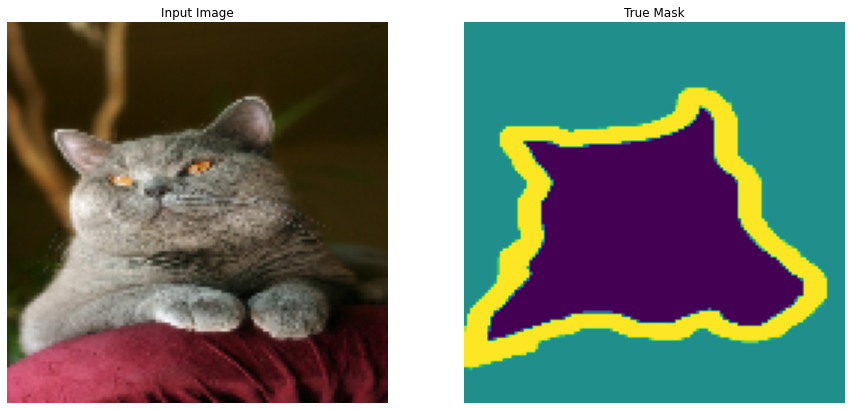

In [ ]:
for image,mask in train.take(3):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

layers_names = [
  'block_1_expand_relu',
  'block_3_expand_relu',
  'block_6_expand_relu',
  'block_13_expand_relu',
  'block_16_project'
]

layers = [base_model.get_layer(name).output for name in layers_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs = layers)

down_stack.trainable = False

In [ ]:
up_stack = [
  pix2pix.upsample(512,3),
  pix2pix.upsample(256,3),
  pix2pix.upsample(128,3),
  pix2pix.upsample(64,3)
]

In [ ]:
def unet_model(output_channels):

  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides = 2, padding = 'same', activation='softmax')

  inputs = tf.keras.layers.Input(shape=[128,128,3])

  x = inputs

  skips = down_stack(x)

  x = skips[-1]

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack,skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x,skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)


In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

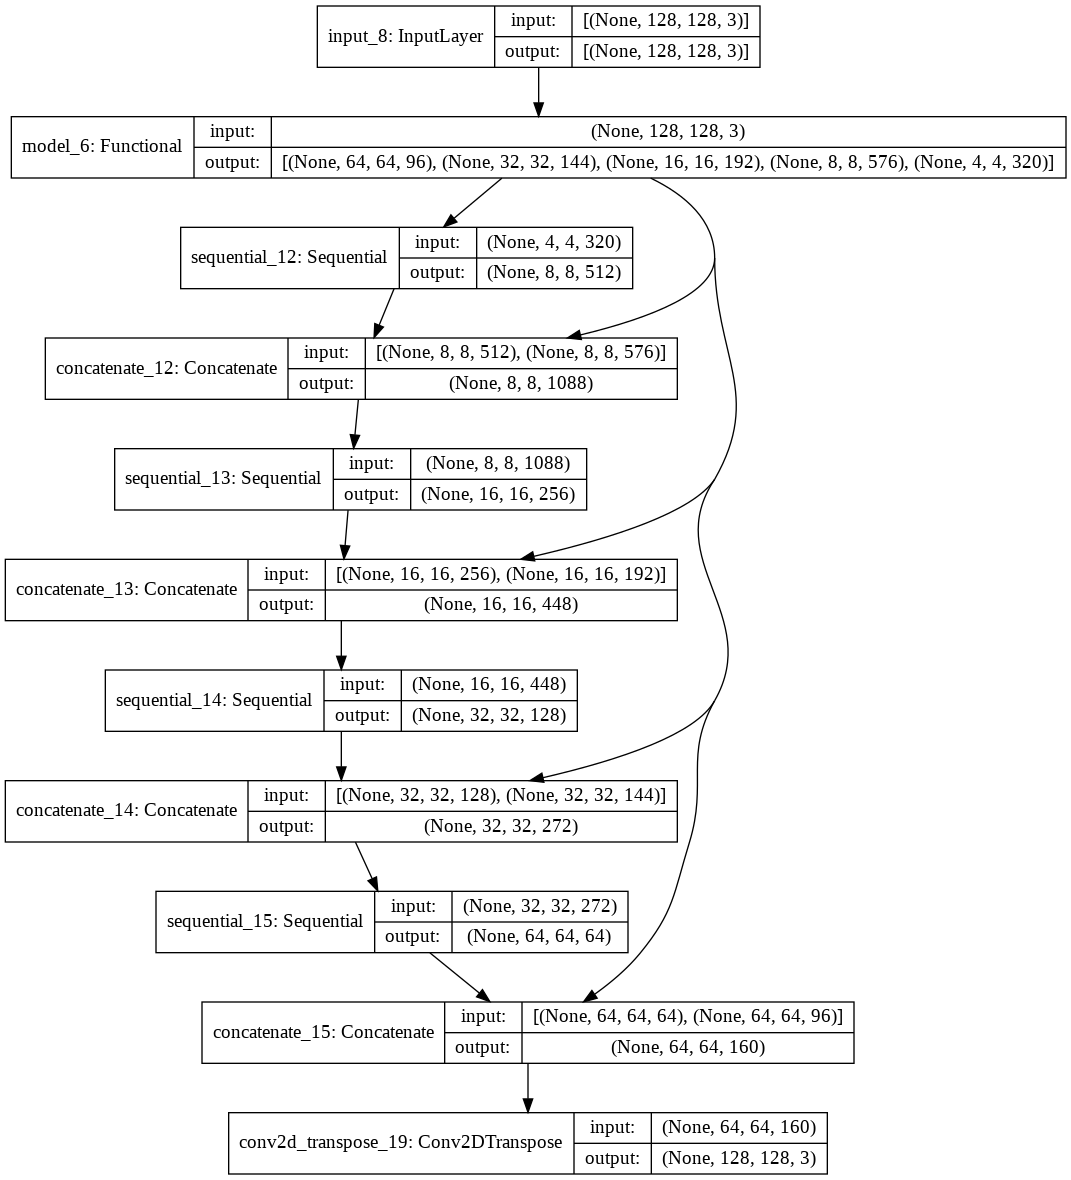

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis = -1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset = None, num = 1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image,sample_mask,create_mask(model.predict(sample_image[tf.newaxis,...]))])

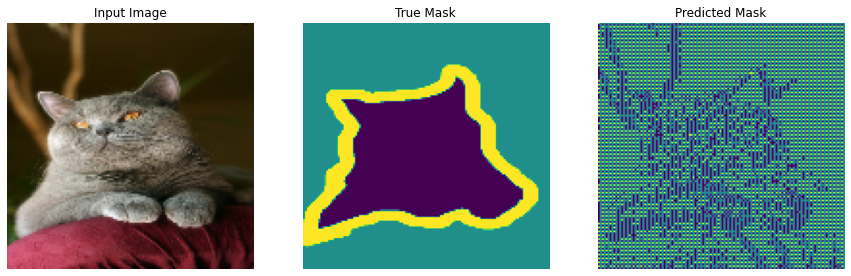

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}\n'.format(epoch+1))

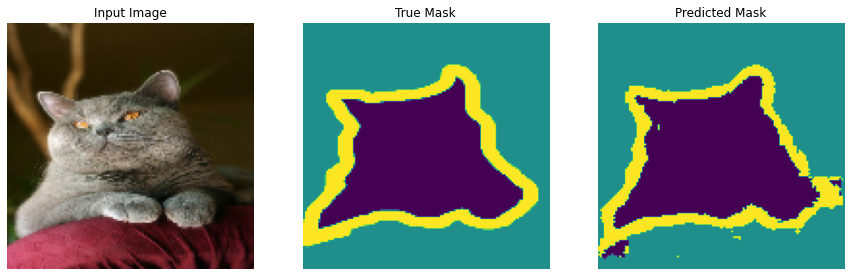


Sample Prediction after epoch 15



In [ ]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs = EPOCHS,
                          steps_per_epoch = SETPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS,
                          validation_data = test_dataset,
                          callbacks = [DisplayCallback()])

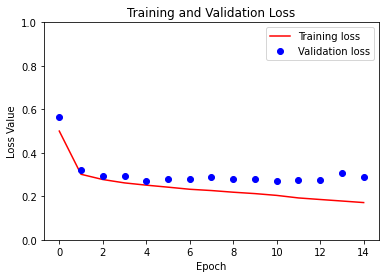

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

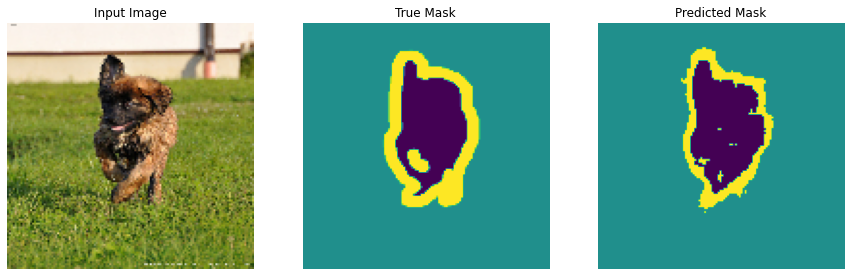

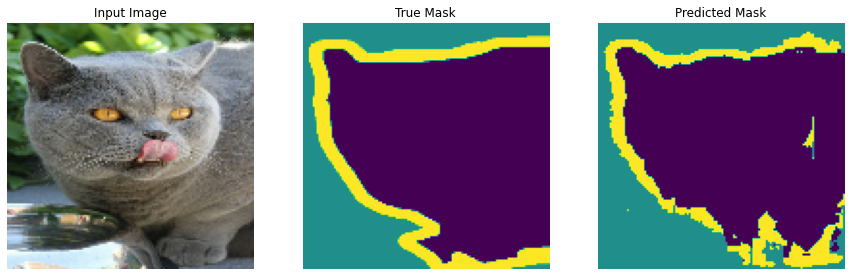

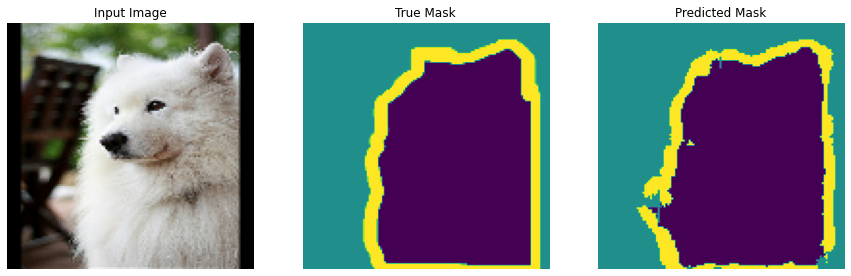

In [ ]:
show_predictions(test_dataset, 3)